https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras.backend as K
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import *
from keras import backend as K
from keras import initializers
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
K.set_image_dim_ordering('th')
from keras.layers.advanced_activations import LeakyReLU

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


Using TensorFlow backend.


(20000, 4000)


(1.0, 0.0)

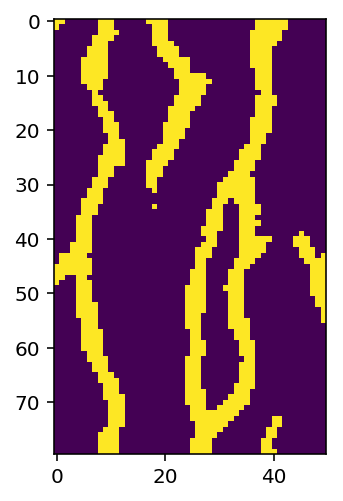

In [2]:
#Now going to go ahead and import and check data to ensure its all good
tr_im = np.loadtxt("reals.dat")
print(tr_im.shape)
nrow,ncol = 80,50
plt.imshow(tr_im[0,:].reshape((nrow,ncol)))
tr_im.max(), tr_im.min()

In [3]:
#Now setting up everyting for the loss fucntion and discriminatior and gen later down the line
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

npar = 200 #number of standard normal deviates to feed to generator input

In [4]:
#other misc preperations
# random seed
RND = 777

# output settings
RUN = 'B'
OUT_DIR = 'out/' + RUN
TENSORBOARD_DIR = '/tensorboard/wgans/' + RUN
SAVE_SAMPLE_IMAGES = False


BATCH_SIZE = 100
ITERATIONS = 20000

# size of the random vector used to initialize G
Z_SIZE = 100
D_ITERS = 5




In [5]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(mean=0.5,stddev=0.002)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.35))
discriminator.add(Conv2D(256, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(512, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss=[d_loss], optimizer=RMSprop(lr=0.00005))
D = discriminator
D.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 40, 25)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 40, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 40, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 20, 13)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 20, 13)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 10, 7)        819456    
__________

In [6]:
#Generator
generator = Sequential()
generator.add(Dense(npar*8*5, input_shape=(npar,), kernel_initializer=keras.initializers.RandomNormal(stddev=0.002)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((npar, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001,beta_1=0.5))
G = generator
G.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8000)              1608000   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8000)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 8, 5)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 16, 10)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 16, 10)       1280256   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 16, 10)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 16, 10)       819328    
__________

In [7]:
D.trainable = False
gi = Input(shape=(npar,))
x = G(gi)
go = D(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss=[d_loss],optimizer=RMSprop(lr=0.00005))

InternalError: Blas GEMM launch failed : a.shape=(10, 200), b.shape=(200, 8000), m=10, n=8000, k=200
	 [[{{node dense_2/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_2_input_0_0/_67, dense_2/kernel/read)]]

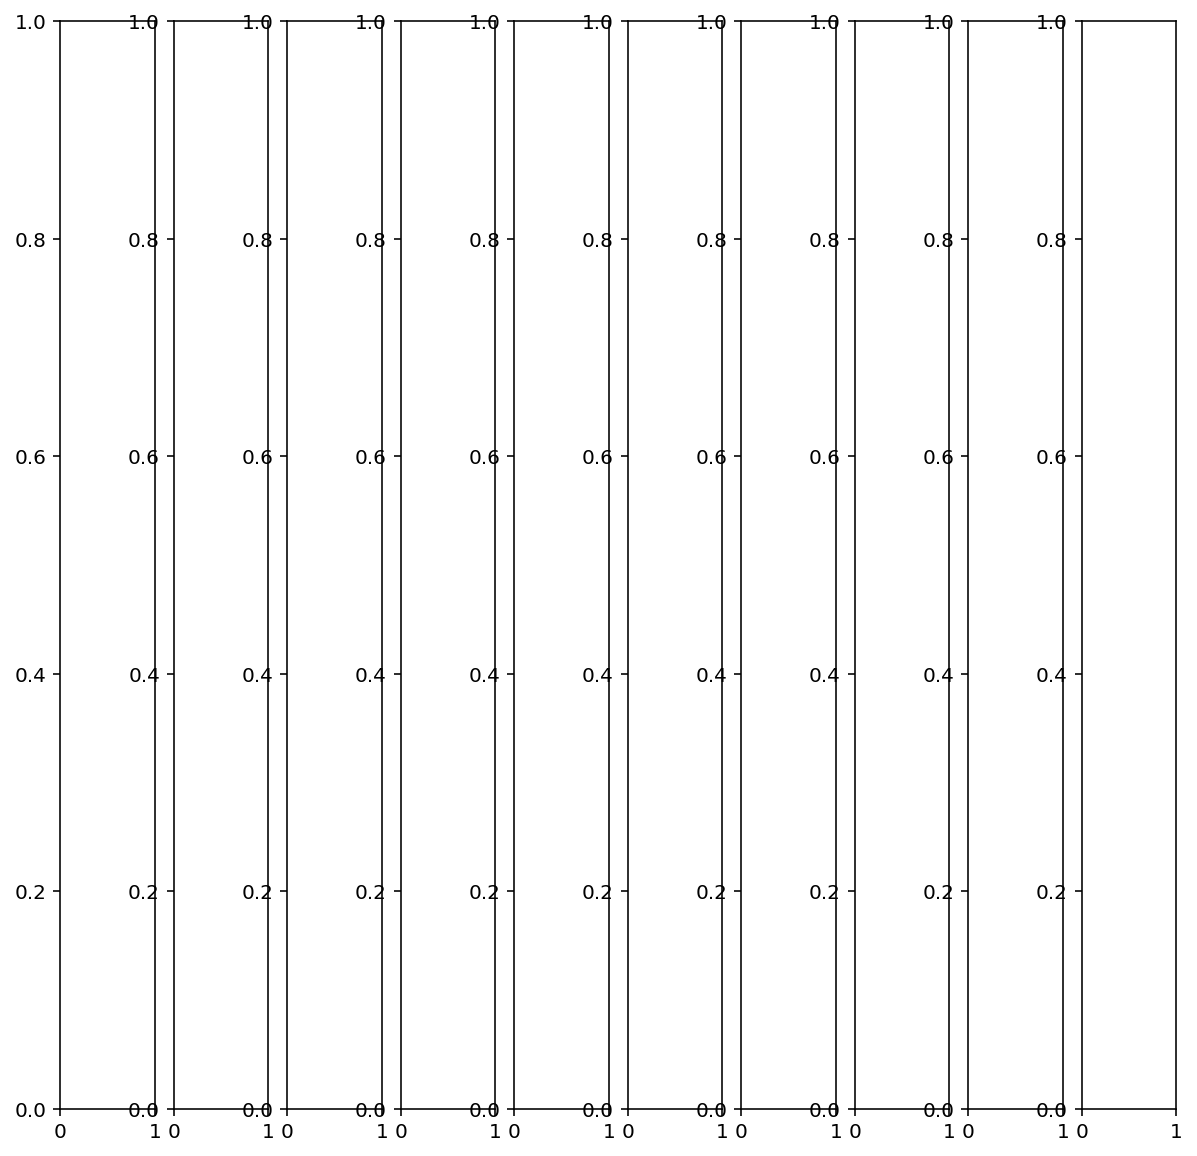

In [8]:
def plot_G():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = G.predict(plot_noise)#.reshape(10,28,28)
    #print(vecs[0,:])
    isreal = D.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_G()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)